6-1 MNIST 분류 학습 모델 (손글씨 숫자 판별) (순차모델 인공신경망)

Epoch 1/10
2100/2100 [==============================] - 4s 2ms/step - loss: 0.7531 - accuracy: 0.7833 - val_loss: 0.3680 - val_accuracy: 0.8970
Epoch 2/10
2100/2100 [==============================] - 3s 1ms/step - loss: 0.3426 - accuracy: 0.9020 - val_loss: 0.2939 - val_accuracy: 0.9124
Epoch 3/10
2100/2100 [==============================] - 3s 1ms/step - loss: 0.2847 - accuracy: 0.9183 - val_loss: 0.2649 - val_accuracy: 0.9214
Epoch 4/10
2100/2100 [==============================] - 3s 1ms/step - loss: 0.2529 - accuracy: 0.9265 - val_loss: 0.2349 - val_accuracy: 0.9328
Epoch 5/10
2100/2100 [==============================] - 3s 1ms/step - loss: 0.2289 - accuracy: 0.9335 - val_loss: 0.2114 - val_accuracy: 0.9388
Epoch 6/10
2100/2100 [==============================] - 3s 1ms/step - loss: 0.2124 - accuracy: 0.9383 - val_loss: 0.2049 - val_accuracy: 0.9412
Epoch 7/10
2100/2100 [==============================] - 3s 1ms/step - loss: 0.2001 - accuracy: 0.9420 - val_loss: 0.1929 - val_accuracy:

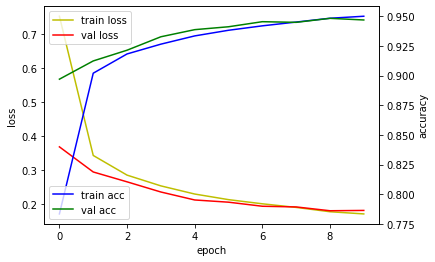

In [1]:
# 필요한 모듈 임포트
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

# MNIST 데이터셋 가져오기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # 데이터 정규화

# tf.data를 사용하여 데이터셋을 섞고 배치 만들기
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000)
train_size = int(len(x_train) * 0.7) # 학습셋:검증셋 = 7:3
train_ds = ds.take(train_size).batch(20)
val_ds = ds.skip(train_size).batch(20)

# MNIST 분류 모델 구성
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(20, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))

# 모델 생성
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# 모델 학습
hist = model.fit(train_ds, validation_data=val_ds, epochs=10)

# 모델 평가
print('모델 평가')
model.evaluate(x_test, y_test)

# 모델 정보 출력
model.summary()

# 모델 저장
model.save('mnist_model.h5')

# 학습 결과 그래프 그리기
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.show()


6-2 MNIST 분류 모델 불러와 활용하기

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
Total params: 16,330
Trainable params: 16,330
Non-trainable params: 0
_________________________________________________________________
313/313 - 0s - loss: 0.1858 - accuracy: 0.9440 - 315ms/epoch - 1ms/step


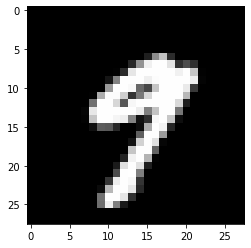

손글씨 이미지 예측값 :  [9]


In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# MNIST 데이터셋 가져오기
_, (x_test, y_test) = mnist.load_data()
x_test = x_test / 255.0 # 데이터 정규화

# 모델 불러오기
model = load_model('mnist_model.h5')
model.summary()
model.evaluate(x_test, y_test, verbose=2)

# 테스트셋에서 20번째 이미지 출력
plt.imshow(x_test[20], cmap="gray")
plt.show()

# 테스트셋의 20번째 이미지 클래스 분류
picks = [20]
y_prob = model.predict(x_test[picks])
predicted = y_prob.argmax(axis=-1)
print("손글씨 이미지 예측값 : ", predicted)

6-3 문장 감정 분류 CNN 모델 (함수모델 인공신경망)

In [3]:
# 필요한 모듈 임포트
import pandas as pd
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, Conv1D, GlobalMaxPool1D, concatenate

# 데이터 읽어오기
train_file = "./chatbot_data.csv"
data = pd.read_csv(train_file, delimiter=',')
features = data['Q'].tolist()
labels = data['label'].tolist()

# 단어 인덱스 시퀀스 벡터
corpus = [preprocessing.text.text_to_word_sequence(text) for text in features]

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
word_index = tokenizer.word_index
MAX_SEQ_LEN = 15  # 단어 시퀀스 벡터 크기
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# 학습용, 검증용, 테스트용 데이터셋 생성 ➌
# 학습셋:검증셋:테스트셋 = 7:2:1
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, labels))
ds = ds.shuffle(len(features))
train_size = int(len(padded_seqs) * 0.7)
val_size = int(len(padded_seqs) * 0.2)
test_size = int(len(padded_seqs) * 0.1)
train_ds = ds.take(train_size).batch(20)
val_ds = ds.skip(train_size).take(val_size).batch(20)
test_ds = ds.skip(train_size + val_size).take(test_size).batch(20)

# 하이퍼파라미터 설정
dropout_prob = 0.5
EMB_SIZE = 128
EPOCH = 5
VOCAB_SIZE = len(word_index) + 1  # 전체 단어 수

# CNN 모델 정의
input_layer = Input(shape=(MAX_SEQ_LEN,))
embedding_layer = Embedding(VOCAB_SIZE, EMB_SIZE, input_length=MAX_SEQ_LEN)(input_layer)
dropout_emb = Dropout(rate=dropout_prob)(embedding_layer)

conv1 = Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool1 = GlobalMaxPool1D()(conv1)
conv2 = Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool2 = GlobalMaxPool1D()(conv2)
conv3 = Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
pool3 = GlobalMaxPool1D()(conv3)

# 3, 4, 5- gram 이후 합치기
concat = concatenate([pool1, pool2, pool3])
hidden = Dense(128, activation=tf.nn.relu)(concat)
dropout_hidden = Dropout(rate=dropout_prob)(hidden)
logits = Dense(3, name='logits')(dropout_hidden)
predictions = Dense(3, activation=tf.nn.softmax)(logits)

# 모델 생성
model = Model(inputs=input_layer, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
model.fit(train_ds, validation_data=val_ds, epochs=EPOCH, verbose=1)

# 모델 평가(테스트 데이터셋 이용)
loss, accuracy = model.evaluate(test_ds, verbose=1)
print('Accuracy: %f' % (accuracy * 100))
print('loss: %f' % (loss))

# 모델 저장
model.save('cnn_model.h5')

Epoch 1/5
414/414 [==============================] - 6s 13ms/step - loss: 0.8844 - accuracy: 0.5725 - val_loss: 0.5210 - val_accuracy: 0.8236
Epoch 2/5
414/414 [==============================] - 5s 13ms/step - loss: 0.5113 - accuracy: 0.8075 - val_loss: 0.2853 - val_accuracy: 0.9154
Epoch 3/5
414/414 [==============================] - 6s 13ms/step - loss: 0.2924 - accuracy: 0.9016 - val_loss: 0.1546 - val_accuracy: 0.9497
Epoch 4/5
414/414 [==============================] - 6s 13ms/step - loss: 0.1875 - accuracy: 0.9409 - val_loss: 0.0823 - val_accuracy: 0.9750
Epoch 5/5
60/60 [==============================] - 0s 2ms/step - loss: 0.0644 - accuracy: 0.9780
Accuracy: 97.800338
loss: 0.064360


6-4 문장 감정 분류 CNN 모델 활용

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import preprocessing

# 데이터 읽어오기
train_file = "./chatbot_data.csv"
data = pd.read_csv(train_file, delimiter=',')
features = data['Q'].tolist()
labels = data['label'].tolist()

# 단어 인덱스 시퀀스 벡터
corpus = [preprocessing.text.text_to_word_sequence(text) for text in features]
tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
MAX_SEQ_LEN = 15 # 단어 시퀀스 벡터 크기
padded_seqs = preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

# 테스트용 데이터셋 생성
ds = tf.data.Dataset.from_tensor_slices((padded_seqs, labels))
ds = ds.shuffle(len(features))
test_ds = ds.take(2000).batch(20) # 테스트 데이터셋

# 감정 분류 CNN 모델 불러오기
model = load_model('cnn_model.h5')
model.summary()
model.evaluate(test_ds, verbose=2)

# 테스트용 데이터셋의 10212번째 데이터 출력
print("단어 시퀀스 : ", corpus[10212])
print("단어 인덱스 시퀀스 : ", padded_seqs[10212])
print("문장 분류(정답) : ", labels[10212])

# 테스트용 데이터셋의 10212번째 데이터 감정 예측
picks = [10212]
predict = model.predict(padded_seqs[picks])
predict_class = tf.math.argmax(predict, axis=1)
print("감정 예측 점수 : ", predict)
print("감정 예측 클래스 : ", predict_class.numpy())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 128)      1715072     ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 15, 128)      0           ['embedding[0][0]']              
                                                                                                  
 conv1d (Conv1D)                (None, 13, 128)      49280       ['dropout[0][0]']                
                                                                                              

6-5 곡선 예측 RNN 모델 사용

shape x:(185, 15) / y:(185,)
train_x.shape = (185, 15, 1)
train_y.shape = (185,)
Epoch 1/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4628
Epoch 2/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3793
Epoch 3/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3048
Epoch 4/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.2434
Epoch 5/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1927
Epoch 6/1000
6/6 [==============================] - 0s 2ms/step - loss: 0.1526
Epoch 7/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.1201
Epoch 8/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0938
Epoch 9/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.0733
Epoch 10/1000
6/6 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 11/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.0443
Epoch 12/1000
6/6 [=============================

6/6 [==============================] - 0s 3ms/step - loss: 1.0803e-04
Epoch 197/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.0616e-04
Epoch 198/1000
6/6 [==============================] - 0s 2ms/step - loss: 1.0465e-04
Epoch 199/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.0494e-04
Epoch 200/1000
6/6 [==============================] - 0s 4ms/step - loss: 1.0235e-04
Epoch 201/1000
6/6 [==============================] - 0s 3ms/step - loss: 1.0083e-04
Epoch 202/1000
6/6 [==============================] - 0s 4ms/step - loss: 1.0004e-04
Epoch 203/1000
6/6 [==============================] - 0s 4ms/step - loss: 9.8753e-05
Epoch 204/1000
6/6 [==============================] - 0s 2ms/step - loss: 9.8524e-05
Epoch 205/1000
6/6 [==============================] - 0s 2ms/step - loss: 9.7958e-05
Epoch 206/1000
6/6 [==============================] - 0s 3ms/step - loss: 9.5677e-05
Epoch 207/1000
6/6 [==============================] - 0s 4ms/step - loss: 9.4455

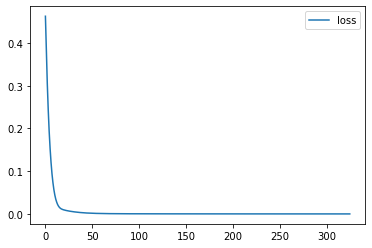

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

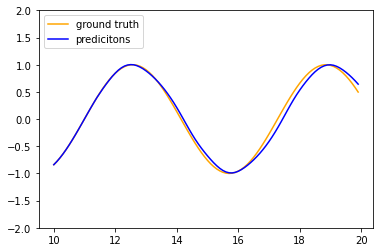

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM, SimpleRNN

# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_idx = i + step
        if end_idx > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)


# sin 함수 학습 데이터
x = [i for i in np.arange(start=-10, stop=10, step=0.1)]
train_y = [np.sin(i) for i in x]

# 하이퍼파라미터
n_timesteps = 15
n_features = 1

# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, step=n_timesteps)
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape))

# RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

# RNN 모델 정의
model = Sequential()
model.add(SimpleRNN(units=10, return_sequences=False, input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, mode='auto')
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

# loss 그래프 생성
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1)
calc_y = np.cos(test_x) # 테스트 정답 데이터

# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
    net_input = test_y[i : i + n_timesteps]
    net_input = net_input.reshape((1, n_timesteps, n_features))
    train_y = model.predict(net_input, verbose=0)
    print(test_y.shape, train_y.shape, i, i + n_timesteps)
    test_y = np.append(test_y, train_y)

# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predicitons", color="blue")
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()

6-6 Sin 곡선 예측 LSTM 모델 사용

shape x:(185, 15) / y:(185,)
train_x.shape = (185, 15, 1)
train_y.shape = (185,)
Epoch 1/1000
6/6 [==============================] - 1s 8ms/step - loss: 0.4930
Epoch 2/1000
6/6 [==============================] - 0s 7ms/step - loss: 0.4316
Epoch 3/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.3750
Epoch 4/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.3276
Epoch 5/1000
6/6 [==============================] - 0s 6ms/step - loss: 0.2830
Epoch 6/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2480
Epoch 7/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.2213
Epoch 8/1000
6/6 [==============================] - 0s 9ms/step - loss: 0.1990
Epoch 9/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1860
Epoch 10/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1743
Epoch 11/1000
6/6 [==============================] - 0s 8ms/step - loss: 0.1663
Epoch 12/1000
6/6 [=============================

6/6 [==============================] - 0s 5ms/step - loss: 6.2587e-05
Epoch 197/1000
6/6 [==============================] - 0s 5ms/step - loss: 6.1235e-05
Epoch 198/1000
6/6 [==============================] - 0s 4ms/step - loss: 5.9828e-05
Epoch 199/1000
6/6 [==============================] - 0s 6ms/step - loss: 5.8624e-05
Epoch 200/1000
6/6 [==============================] - 0s 7ms/step - loss: 5.7760e-05
Epoch 201/1000
6/6 [==============================] - 0s 7ms/step - loss: 5.6326e-05
Epoch 202/1000
6/6 [==============================] - 0s 6ms/step - loss: 5.5326e-05
Epoch 203/1000
6/6 [==============================] - 0s 6ms/step - loss: 5.4304e-05
Epoch 204/1000
6/6 [==============================] - 0s 6ms/step - loss: 5.2856e-05
Epoch 205/1000
6/6 [==============================] - 0s 7ms/step - loss: 5.2019e-05
Epoch 206/1000
6/6 [==============================] - 0s 6ms/step - loss: 5.0974e-05
Epoch 207/1000
6/6 [==============================] - 0s 6ms/step - loss: 4.9797

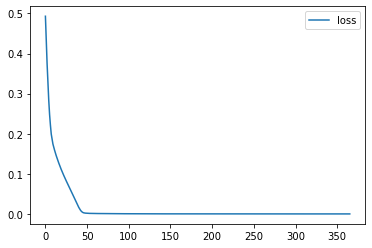

(15,) (1, 1) 0 15
(16,) (1, 1) 1 16
(17,) (1, 1) 2 17
(18,) (1, 1) 3 18
(19,) (1, 1) 4 19
(20,) (1, 1) 5 20
(21,) (1, 1) 6 21
(22,) (1, 1) 7 22
(23,) (1, 1) 8 23
(24,) (1, 1) 9 24
(25,) (1, 1) 10 25
(26,) (1, 1) 11 26
(27,) (1, 1) 12 27
(28,) (1, 1) 13 28
(29,) (1, 1) 14 29
(30,) (1, 1) 15 30
(31,) (1, 1) 16 31
(32,) (1, 1) 17 32
(33,) (1, 1) 18 33
(34,) (1, 1) 19 34
(35,) (1, 1) 20 35
(36,) (1, 1) 21 36
(37,) (1, 1) 22 37
(38,) (1, 1) 23 38
(39,) (1, 1) 24 39
(40,) (1, 1) 25 40
(41,) (1, 1) 26 41
(42,) (1, 1) 27 42
(43,) (1, 1) 28 43
(44,) (1, 1) 29 44
(45,) (1, 1) 30 45
(46,) (1, 1) 31 46
(47,) (1, 1) 32 47
(48,) (1, 1) 33 48
(49,) (1, 1) 34 49
(50,) (1, 1) 35 50
(51,) (1, 1) 36 51
(52,) (1, 1) 37 52
(53,) (1, 1) 38 53
(54,) (1, 1) 39 54
(55,) (1, 1) 40 55
(56,) (1, 1) 41 56
(57,) (1, 1) 42 57
(58,) (1, 1) 43 58
(59,) (1, 1) 44 59
(60,) (1, 1) 45 60
(61,) (1, 1) 46 61
(62,) (1, 1) 47 62
(63,) (1, 1) 48 63
(64,) (1, 1) 49 64
(65,) (1, 1) 50 65
(66,) (1, 1) 51 66
(67,) (1, 1) 52 67
(68

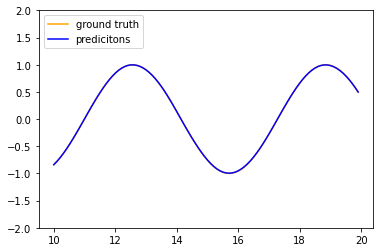

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, LSTM

# time step만큼 시퀀스 데이터 분리
def split_sequence(sequence, step):
    x, y = list(), list()

    for i in range(len(sequence)):
        end_idx = i + step
        if end_idx > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
        x.append(seq_x)
        y.append(seq_y)

    return np.array(x), np.array(y)


# sin 함수 학습 데이터
x = [i for i in np.arange(start=-10, stop=10, step=0.1)]
train_y = [np.sin(i) for i in x]

# 하이퍼파라미터
n_timesteps = 15
n_features = 1

# 시퀀스 나누기
# train_x.shape => (samples, timesteps)
# train_y.shape => (samples)
train_x, train_y = split_sequence(train_y, step=n_timesteps)
print("shape x:{} / y:{}".format(train_x.shape, train_y.shape))

# RNN 입력 벡터 크기를 맞추기 위해 벡터 차원 크기 변경
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)
print("train_x.shape = {}".format(train_x.shape))
print("train_y.shape = {}".format(train_y.shape))

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=10, return_sequences=False, input_shape=(n_timesteps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 학습
np.random.seed(0)
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=5, mode='auto')
history = model.fit(train_x, train_y, epochs=1000, callbacks=[early_stopping])

# loss 그래프 생성
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.show()

# 테스트 데이터셋 생성
test_x = np.arange(10, 20, 0.1)
calc_y = np.cos(test_x) # 테스트 정답 데이터

# RNN 모델 예측 및 로그 저장
test_y = calc_y[:n_timesteps]
for i in range(len(test_x) - n_timesteps):
    net_input = test_y[i : i + n_timesteps]
    net_input = net_input.reshape((1, n_timesteps, n_features))
    train_y = model.predict(net_input, verbose=0)
    print(test_y.shape, train_y.shape, i, i + n_timesteps)
    test_y = np.append(test_y, train_y)

# 예측 결과 그래프 그리기
plt.plot(test_x, calc_y, label="ground truth", color="orange")
plt.plot(test_x, test_y, label="predicitons", color="blue")
plt.legend(loc='upper left')
plt.ylim(-2, 2)
plt.show()

6-7 양방향 LSTM

In [7]:
import numpy as np
from random import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed


# 시퀀스 생성
def get_sequence(n_timesteps):
    # 0~1 사이의 랜덤 시퀀스 생성
    X = np.array([random() for _ in range(n_timesteps)])

    # 클래스 분류 기준
    limit = n_timesteps / 4.0

    # 누적합 시퀀스에서 클래스 결정
    # 누적합 항목이 limit보다 작은 경우 0, 아닌 경우 1로 분류
    y = np.array([0 if x < limit else 1 for x in np.cumsum(X)])

    # LSTM 입력을 위해 3차원 텐서 형태로 변경
    X = X.reshape(1, n_timesteps, 1)
    y = y.reshape(1, n_timesteps, 1)
    return X, y


# 하이퍼파라미터 정의
n_units = 20
n_timesteps = 4

# 양방향 LSTM 모델 정의
model = Sequential()
model.add(Bidirectional(LSTM(n_units, return_sequences=True, input_shape=(n_timesteps, 1))))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
# 에포크마다 학습 데이터를 생성해서 학습
for epoch in range(1000):
    X, y = get_sequence(n_timesteps)
    model.fit(X, y, epochs=1, batch_size=1, verbose=2)

# 모델 평가
X, y = get_sequence(n_timesteps)
prob = model.predict(X, verbose=0)
yhat = prob.argmax(axis=-1)
for i in range(n_timesteps):
    print('실젯값 :', y[0, i], '예측값 : ', yhat[0, i])
    

1/1 - 2s - loss: 0.7096 - accuracy: 0.5000 - 2s/epoch - 2s/step
1/1 - 0s - loss: 0.6920 - accuracy: 0.5000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.7329 - accuracy: 0.2500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6996 - accuracy: 0.5000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.7186 - accuracy: 0.2500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6931 - accuracy: 0.5000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6887 - accuracy: 0.5000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6900 - accuracy: 0.5000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.7160 - accuracy: 0.2500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6889 - accuracy: 0.5000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.7044 - accuracy: 0.2500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6800 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6824 - accuracy: 0.5000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.6846 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.6803 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - l

1/1 - 0s - loss: 0.3690 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4664 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4166 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.3302 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4266 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.3462 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.4022 - accuracy: 0.7500 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.4041 - accuracy: 0.7500 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.4004 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4612 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.3110 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.3353 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.3272 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.3833 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.3870 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.2795 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2079 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2429 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.3894 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2982 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2453 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.5537 - accuracy: 0.7500 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.2337 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1661 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2510 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2010 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4430 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1450 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.3390 - accuracy: 0.7500 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.9649 - accuracy: 0.5000 - 4ms/epoch - 4ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.1270 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4325 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6521 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2633 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1906 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.3193 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.5450 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 1.0235 - accuracy: 0.5000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.2027 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1602 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.1299 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.5892 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1798 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.9717 - accuracy: 0.5000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1137 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.5156 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1126 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0889 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1736 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1473 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1459 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2079 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1973 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.1552 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2421 - accuracy: 0.7500 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.1379 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1685 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4649 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1690 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1880 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.1403 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1560 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.2646 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1071 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1172 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1054 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.0991 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0918 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.1009 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.2303 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1286 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1080 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.6048 - accuracy: 0.7500 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.2066 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0735 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.1137 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4390 - accuracy: 0.7500 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.3847 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1177 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1101 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1613 - accuracy: 1.0000 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.1514 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1314 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4979 - accuracy: 0.7500 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1283 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.5401 - accuracy: 0.7500 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1254 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.4115 - accuracy: 0.7500 - 5ms/epoch - 5ms/step
1/1 - 0s - loss: 0.1450 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0926 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s -

1/1 - 0s - loss: 0.1757 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1719 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1187 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1266 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1576 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1008 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1016 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1796 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1479 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1133 - accuracy: 1.0000 - 3ms/epoch - 3ms/step
1/1 - 0s - loss: 0.1670 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0658 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.1646 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0573 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s - loss: 0.0816 - accuracy: 1.0000 - 4ms/epoch - 4ms/step
1/1 - 0s -

실젯값 : [0] 예측값 :  0


IndexError: index 1 is out of bounds for axis 1 with size 1

6-8 양방향 LSTM을 이용한 NER

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np


# 학습 파일 불러오기
def read_file(file_name):
    sents = []
    with open(file_name, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for idx, l in enumerate(lines):
            if l[0] == ';' and lines[idx + 1][0] == '$':
                this_sent = []
            elif l[0] == '$' and lines[idx - 1][0] == ';':
                continue
            elif l[0] == '\n':
                sents.append(this_sent)
            else:
                this_sent.append(tuple(l.split()))
    return sents


# 학습용 말뭉치 데이터를 불러옴
corpus = read_file('train.txt')

# 말뭉치 데이터에서 단어와 BIO 태그만 불러와 학습용 데이터셋 생성
sentences, tags = [], []
for t in corpus:
    tagged_sentence = []
    sentence, bio_tag = [], []
    for w in t:
        tagged_sentence.append((w[1], w[3]))
        sentence.append(w[1])
        bio_tag.append(w[3])

    sentences.append(sentence)
    tags.append(bio_tag)

print("샘플 크기 : \n", len(sentences))
print("0번째 샘플 문장 시퀀스 : \n", sentences[0])
print("0번째 샘플 bio 태그 : \n", tags[0])
print("샘플 문장 시퀀스 최대 길이 :", max(len(l) for l in sentences))
print("샘플 문장 시퀀스 평균 길이 :", (sum(map(len, sentences))/len(sentences)))


# 토크나이저 정의
sent_tokenizer = preprocessing.text.Tokenizer(oov_token='OOV') # 첫 번째 인덱스에는 OOV 사용
sent_tokenizer.fit_on_texts(sentences)
tag_tokenizer = preprocessing.text.Tokenizer(lower=False) # 태그 정보는 lower= False 소문자로 변환하지 않는다.
tag_tokenizer.fit_on_texts(tags)

# 단어 사전 및 태그 사전 크기
vocab_size = len(sent_tokenizer.word_index) + 1
tag_size = len(tag_tokenizer.word_index) + 1
print("BIO 태그 사전 크기 :", tag_size)
print("단어 사전 크기 :", vocab_size)

# 학습용 단어 시퀀스 생성
x_train = sent_tokenizer.texts_to_sequences(sentences)
y_train = tag_tokenizer.texts_to_sequences(tags)
print(x_train[0])
print(y_train[0])

# index to word / index to NER 정의
index_to_word = sent_tokenizer.index_word # 시퀀스 인덱스를 단어로 변환하기 위해 사용
index_to_ner = tag_tokenizer.index_word # 시퀀스 인덱스를 NER로 변환하기 위해 사용
index_to_ner[0] = 'PAD'

# 시퀀스 패딩 처리
max_len = 40
x_train = preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=max_len)
y_train = preprocessing.sequence.pad_sequences(y_train, padding='post', maxlen=max_len)

# 학습 데이터와 테스트 데이터를 8:2 비율로 분리
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=.2, random_state=0)

# 출력 데이터를 원-핫 인코딩
y_train = tf.keras.utils.to_categorical(y_train, num_classes=tag_size)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=tag_size)

print("학습 샘플 시퀀스 형상 : ", x_train.shape)
print("학습 샘플 레이블 형상 : ", y_train.shape)
print("테스트 샘플 시퀀스 형상 : ", x_test.shape)
print("테스트 샘플 레이블 형상 : ", y_test.shape)

# 모델 정의(Bi-LSTM)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=30, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.50, recurrent_dropout=0.25)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.01), metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=10)
print("평가 결과 : ", model.evaluate(x_test, y_test)[1])


# 시퀀스를 NER 태그로 변환
def sequences_to_tag(sequences):
    result = []
    for sequence in sequences:
        temp = []
        for pred in sequence:
            pred_index = np.argmax(pred)
            temp.append(index_to_ner[pred_index].replace("PAD", "O"))
        result.append(temp)
    return result


# 테스트 데이터셋의 NER 예측
y_predicted = model.predict(x_test) # (711, 40) => model => (711, 40, 8)
pred_tags = sequences_to_tag(y_predicted) # 예측된 NER
test_tags = sequences_to_tag(y_test) # 실제 NER

# F1 스코어 계산을 위해 사용
from seqeval.metrics import f1_score, classification_report
print(classification_report(test_tags, pred_tags))
print("F1-score: {:.1%}".format(f1_score(test_tags, pred_tags)))


# 새로운 유형의 문장 NER 예측
word_to_index = sent_tokenizer.word_index
new_sentence = '전자공학과 김상배 교수 카리스마 입장.'.split()
new_x = []
for w in new_sentence:
    try:
        new_x.append(word_to_index.get(w, 1))
    except KeyError:
        # 모르는 단어의 경우 OOV
        new_x.append(word_to_index['OOV'])

print("새로운 유형의 시퀀스 : ", new_x)
new_padded_seqs = preprocessing.sequence.pad_sequences([new_x], padding="post", value=0, maxlen=max_len)

# NER 예측
p = model.predict(np.array([new_padded_seqs[0]]))
p = np.argmax(p, axis=-1) # 예측된 NER 인덱스값 추출
print("{:10} {:5}".format("단어", "예측된 NER"))
print("-" * 50)

for w, pred in zip(new_sentence, p[0]):
    print("{:10} {:5}".format(w, index_to_ner[pred]))



샘플 크기 : 
 3555
0번째 샘플 문장 시퀀스 : 
 ['한편', ',', 'AFC', '챔피언스', '리그', 'E', '조', '에', '속하', 'ㄴ', '포항', '역시', '대회', '8강', '진출', '이', '불투명', '하', '다', '.']
0번째 샘플 bio 태그 : 
 ['O', 'O', 'O', 'O', 'O', 'B_OG', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
샘플 문장 시퀀스 최대 길이 : 168
샘플 문장 시퀀스 평균 길이 : 34.03909985935302
BIO 태그 사전 크기 : 8
단어 사전 크기 : 13834
[183, 11, 4276, 884, 162, 931, 402, 10, 2608, 7, 1516, 608, 145, 1361, 414, 4, 6347, 2, 8, 3]
[1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
학습 샘플 시퀀스 형상 :  (2844, 40)
학습 샘플 레이블 형상 :  (2844, 40, 8)
테스트 샘플 시퀀스 형상 :  (711, 40)
테스트 샘플 레이블 형상 :  (711, 40, 8)
Epoch 1/10
23/23 [==============================] - 10s 300ms/step - loss: 0.5041 - accuracy: 0.8396
Epoch 2/10
23/23 [==============================] - 7s 311ms/step - loss: 0.2315 - accuracy: 0.8982
Epoch 3/10
23/23 [==============================] - 7s 315ms/step - loss: 0.1500 - accuracy: 0.9283
Epoch 4/10
23/23 [==============================] - 7s 318ms/step -

C:\Users\GyeongMinKim\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_DT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\GyeongMinKim\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_PS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\GyeongMinKim\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_OG seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\GyeongMinKim\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_TI seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\GyeongMinKim\anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: B_LC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

           _       0.62      0.55      0.58       657
         _DT       0.88      0.90      0.89       335
         _LC       0.76      0.51      0.61       312
         _OG       0.72      0.51      0.60       481
         _PS       0.84      0.37      0.52       374
         _TI       0.94      0.71      0.81        66

   micro avg       0.74      0.56      0.64      2225
   macro avg       0.79      0.59      0.67      2225
weighted avg       0.75      0.56      0.63      2225

F1-score: 63.9%
새로운 유형의 시퀀스 :  [1, 1, 450, 5134, 1]
단어         예측된 NER
--------------------------------------------------
전자공학과      B_OG 
김상배        I    
교수         O    
카리스마       O    
입장.        O    
